<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Модель-1:-Дерево-решений" data-toc-modified-id="Модель-1:-Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель 1: Дерево решений</a></span></li><li><span><a href="#Модель-2:-Случайный-лес" data-toc-modified-id="Модель-2:-Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель 2: Случайный лес</a></span></li><li><span><a href="#&quot;Глупая&quot;-модель" data-toc-modified-id="&quot;Глупая&quot;-модель-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>"Глупая" модель</a></span></li></ul></li><li><span><a href="#Проверка-качества-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-качества-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка качества модели на тестовой выборке</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать **коэффициент** восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [48]:
#загружаем все необходимые библиотеки функции
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ggplot as gg

In [87]:
from ggplot import aes
from ggplot import geom_boxplot
from ggplot import facet_wrap
from ggplot import facet_grid

In [49]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

#import sklearn.metrics
#from sklearn import

In [50]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')


In [51]:
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')


In [52]:
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')


## Подготовка данных

In [1]:
#Посмотрим на данные

data = [train, test, full]

for df in data:
    display(df.head())
    display(df.shape)
    display(df.info())
    print()
    print("Пропуски:", df.isna().sum())
    print()
    print("Явные дубликаты:", df.duplicated().sum())
    print()

------
**Проверим формулу вычисления эффективности обогащения**

Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 

Формула рассчета эффективности обогащения: recovery = ((C * (F - T)) / (F * (C - T))) * 100 

Где <br>
- С — доля золота в концентрате после флотации/очистки - Final Au
- F — доля золота в сырье/концентрате до флотации/очистки - Rougher Au
- T — доля золота в отвальных хвостах после флотации/очистки - Rougher tails

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


**Релевантные колонки**

final.output.concentrate_au <br>
final.output.tail_au <br>

primary_cleaner.output.concentrate_au <br>
primary_cleaner.output.tail_au <br>
secondary_cleaner.output.tail_au <br>

rougher.input.feed_au <br>
rougher.output.concentrate_au <br>
rougher.output.tail_au <br>

Проверим, что эффективность обогащения рассчитана правильно. 
Вычислим её на обучающей выборке для признака rougher.output.recovery. 


In [54]:
def recovery(C, F, T):
    recovery = ((C * (F - T)) / (F * (C - T)))*100
    return recovery

In [55]:
rougher_recovery = recovery(train['rougher.output.concentrate_au'],train['rougher.input.feed_au']\
                            ,train['rougher.output.tail_au'])

print(rougher_recovery.mean())
train['rougher.output.recovery'].mean()

82.70450164550269


82.70450164550267

Найдем MAE между вашими расчётами и значением признака.

In [56]:
rougher_mae = mean_absolute_error(train['rougher.output.recovery'],rougher_recovery)
print(rougher_mae)
rougher_mape = mean_absolute_percentage_error(train['rougher.output.recovery'],rougher_recovery)
print(rougher_mape)

9.73512347450521e-15
1.1598012478556472e-16


**Выводы**: Ура, средние почти одинаковые, а MAE близка к нулю. Похоже, эффективность обогащения рассчитана правильно!

------
**Проанализируем признаки, недоступные в тестовой выборке**

Первым делом посмотрим, какими признаками различаются train и test

In [57]:
missing_cols = []
same_cols = []
new_cols = []

for col in train.columns:
    if col in test.columns:
        same_cols.append(col)
    else:
        missing_cols.append(col)
        
for col in test.columns:
    if col not in train.columns:
        new_cols.append(col)

In [58]:
print("Признаки недоступны в тестовой выборке")
display(missing_cols)

print("Новые признаки в тестовой выборке")
print(new_cols)

Признаки недоступны в тестовой выборке


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Новые признаки в тестовой выборке
[]


**Выводы:**

Параметры, которых нет в тестовой выборке (типы output и calculation) - это замеры концентраций разных элементов (золота и примесей) в продукте и в хвостах **после** проведения флотации и очистки, а также коэффициенты эффективности обогащения после каждого этапа. Логично, как раз эти параметры нам и требуется предсказать исходя из стартовых концентратов и параметров самой процедуры очистки.

Имеет смысл отбросить эти признаки из обучающей выборке, чтобы "не подглядывать" таким образом в целевой признак.

------
**Проведем предобработку данных**

In [59]:
#сразу отбросим пропуски в тестовом датасете, их немного, а заменять их было бы некорректно
test.dropna(inplace = True)
test.isna().sum().sum()
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [60]:
#В обучающей выборки иногда попадаются нули, которые больше похожи на ошибки, чем на реальные данные
#Первым шагом заменим их на пропуски

train = train.replace({'0':np.nan, 0:np.nan})

Так как нам известно, что данные индексируются датой и временем получения информации (признак date) и соседние по времени параметры часто похожи, заполним пропуски в обучающей выборке с помощью интерполяции.

In [61]:
train = train.interpolate()

In [62]:
print(train.isna().sum().sum())
train[train == 0].sum().sum()

0


0.0

Дальше отбросим из обучающей выборки лишние признаки.

In [63]:
features_train = train[same_cols]
features_train.set_index('date', drop = True, inplace = True)
features_train.shape

(14149, 52)

In [64]:
#Масштабируем не-целевые признаки по обучающей выборке на обучающей и тестовой выборке

scaler = StandardScaler()

scaler.fit(features_train) #fitting scaler to train features

features_train = pd.DataFrame(scaler.transform(features_train),\
                              columns = features_train.columns, index = features_train.index)

In [65]:
features_test = test[same_cols]
features_test.set_index('date', drop = True, inplace = True) #сохраним индекc
features_test = pd.DataFrame(scaler.transform(features_test),\
                             columns = features_test.columns, index = features_test.index)

По логике вещей параметры первой и второй очистки не могут влиять на эффективность обогащения чернового концентрата, как как происходят после его получения. Разделим признаки на две части для двух предсказаний - чернового и финального концетрата.

In [20]:
rougher_cols = features_train.columns[features_train.columns.str.contains('rougher')]
features_train_rougher = features_train[rougher_cols] #для обучающей выборки

In [66]:
features_test_rougher = features_test[rougher_cols] #для тестовой выборки

Создадим датасеты с целевым признаком для чернового и итогового концетрата для обучающей и тестовой выборок

In [67]:
target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery']

In [68]:
full_date_index = full.set_index('date', drop = True)

In [69]:
target_rougher_test = full_date_index.loc[features_test.index]['rougher.output.recovery']
target_final_test = full_date_index.loc[features_test.index]['final.output.recovery']

Теперь у нас есть:

Параметры для **обучающей** выборки для чернового концентрата - features_train_rougher <br>
Целевой признак для обучающей выборки для чернового концентрата- target_rougher_train

Параметры для обучающей выборки для финального концентрата - features_train <br>
Целевой признак для обучающей выборки для финального концентрата- target_final_train

Параметры для **тестовой** выборки для чернового концентрата - features_test_rougher <br>
Целевой признак для тестовой выборки для чернового концентрата- target_rougher_test

Параметры для **тестовой** выборки для финального концентрата - features_test <br>
Целевой признак для тестовой выборки для финального концентрата- target_final_test

----
Нужно будет обучить две модели - для чернового и для финального концентрата на обучающей выборке, а затем подсчитать sMAPE на данных тестовой выборки для этих двух моделей.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [25]:
#Возьмем концетрации металлов из полного датасета (full) 
#Построим боксплоты
output_strings = ['output.concentrate_au','output.concentrate_pb','output.concentrate_ag',\
                  'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_ag']

metall_cols = []
for string in output_strings:
    for col in full.columns:
        if string in col:
            metall_cols.append(col)

metalls_df = full[metall_cols]
metalls_df.dropna(inplace = True)
metalls_df.reset_index(inplace = True)

metalls_df_long = metalls_df.melt(id_vars = 'index', var_name = 'stage_metall'\
                                          , value_name = 'concentrate', value_vars=\
                                          metalls_df.columns[1:])
metalls_df_long[['stage', 'metall']] = metalls_df_long['stage_metall'].str.rsplit('_', 1, expand=True)
metalls_df_long = metalls_df_long.drop(['stage_metall', 'index'], axis = 1)

di = {'final.output.concentrate': 3,
     'rougher.input.feed': 0,
     'rougher.output.concentrate': 1,
     'primary_cleaner.output.concentrate': 2}

metalls_df_long['stage'].replace(di, inplace=True)

#так, теперь превратим стадии обратно в колонки
metalls_df_wide_metalls = metalls_df_long['metall']
metalls_df_wide = metalls_df_long.drop('metall', axis = 1)
metalls_df_wide = metalls_df_long.pivot(columns = 'stage', values = ['concentrate'])
metalls_df_wide['metall'] = metalls_df_wide_metalls


C:\Users\User\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


ag         AxesSubplot(0.1,0.15;0.235294x0.75)
au    AxesSubplot(0.382353,0.15;0.235294x0.75)
pb    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

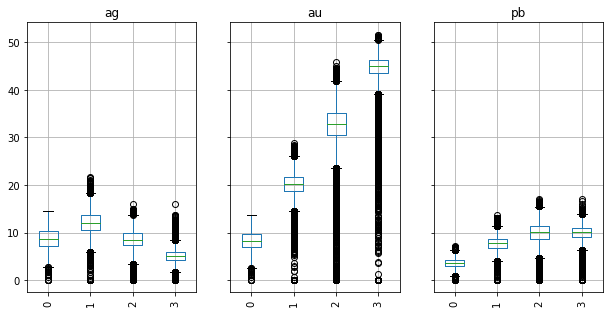

In [26]:
metalls_df_wide.groupby('metall')['concentrate'].boxplot(rot=90, fontsize=10, figsize = (10,5),subplots=True, layout = (1, 3))

**Выводы:** Видно, что в среднем концетрация золота (au) растет с каждым этапом, концентрация серебра (ag) вырастает после флотации, но затем падает, а концетрация свинца (pb) слегка вырастает после флотации и после первой очистки, а затем остается примерно на одном уровне.

----

In [90]:
p10 = (
    gg.ggplot(metalls_df_long, aes("stage", "concentrate"))
    + facet_grid('metall')
    + geom_boxplot()
    + gg.xlab("Stage")
    + gg.ylab("Concentration")
)

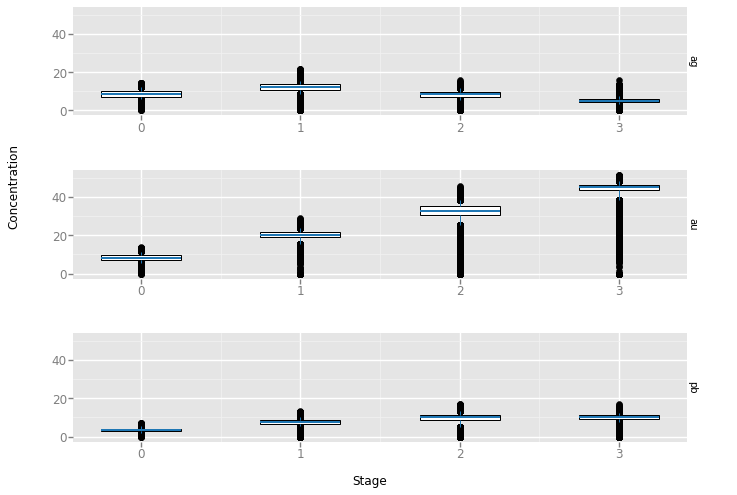

<ggplot: (135072903629)>

In [91]:
p10

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [27]:
col_list = full.columns[full.columns.str.contains('feed_size')]
feed_size_train = train[col_list]
feed_size_test = test[col_list]
feed_size_train['sample'] = 'train'
feed_size_test['sample'] = 'test'
feed_size = pd.concat([feed_size_train, feed_size_test])
feed_size.head()

C:\Users\User\AppData\Local\Temp/ipykernel_3576/871465379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feed_size_train['sample'] = 'train'
C:\Users\User\AppData\Local\Temp/ipykernel_3576/871465379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feed_size_test['sample'] = 'test'


,primary_cleaner.input.feed_size,rougher.input.feed_size,sample
0,7.25,55.486599,train
1,7.25,57.278666,train
2,7.25,57.510649,train
3,7.25,57.792734,train
4,7.25,56.047189,train


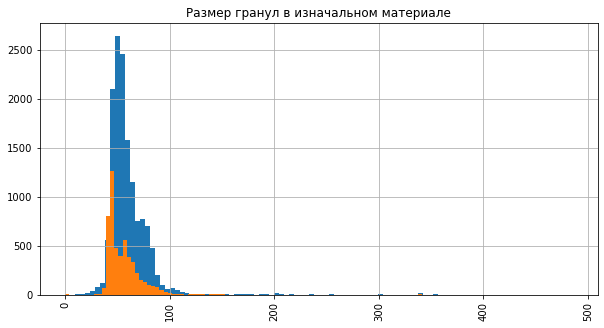

In [28]:
feed_size.query('sample == "train"')['rougher.input.feed_size']\
.hist(bins = 100,figsize = (10,5))
feed_size.query('sample == "test"')['rougher.input.feed_size']\
.hist(bins = 100)
plt.xticks(rotation=90)
plt.title("Размер гранул в изначальном материале")
plt.show()

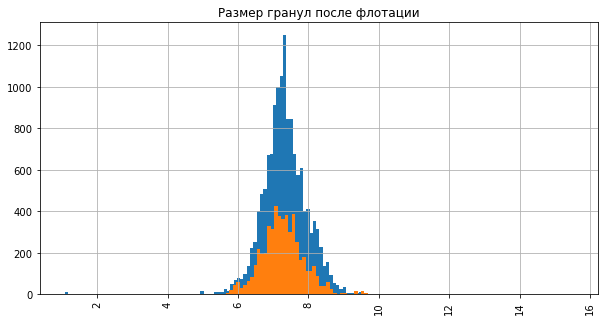

In [29]:
feed_size.query('sample == "train"')['primary_cleaner.input.feed_size']\
.hist(bins = 100,figsize = (10,5))
feed_size.query('sample == "test"')['primary_cleaner.input.feed_size']\
.hist(bins = 100)
plt.xticks(rotation=90)
plt.title('Размер гранул после флотации')
plt.show()

**Выводы:** В целом мы видим, что распределение размера гранул сырья на этапе после флотации похожи (зрительно слегка сбивают выбросы в обучающей выборке), большинство значений попадает в интервал между 6 и 9. Распределения размера гранул до флотации сильнее отличаются на тестовой и обучающей выборке. Значения остаются примерно в одном диапазоне, однако в распределении тестовой выборки мы видим два пика, а также скошенность вправо, относительно распределения обучающей выборки.

----    

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [30]:
#Возьмем полный датасет 

#нам нужно по четыре колонки (четыре вещества) для каждого из трех этапов. 
#Соберем их в отдельный датасет

concentrate_strings = ['final.output.concentrate','rougher.output.concentrate',\
                    'rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_sol',\
                   'rougher.input.feed_pb']
concentrate_cols = []
for string in concentrate_strings:
    for col in full.columns:
        if string in col:
            concentrate_cols.append(col)

concentrate_df = full[concentrate_cols]
concentrate_df.dropna(inplace = True)
concentrate_df.reset_index(inplace = True)

C:\Users\User\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [31]:
#Сделаем табличку со всеми концентрациями, сгруппированными по материалу и этапу

concentrate_df_long = concentrate_df.melt(id_vars = 'index', var_name = 'metall'\
                                          , value_name = 'concentrate', value_vars=\
                                          concentrate_df.columns[1:13])
concentrate_df_long[['stage', 'material']] = concentrate_df_long['metall'].str.split('_', 1, expand=True)
concentrate_df_long = concentrate_df_long.drop(['metall', 'index'], axis = 1)

In [32]:
#Подсчитаем суммарные концентрации для всех материалов по стадиям
concentration_summed = pd.pivot_table(concentrate_df_long, values='concentrate',
                       columns=['stage'], aggfunc=np.sum, dropna = False).transpose()
concentration_summed.reset_index(inplace = True)

In [33]:
di = {'final.output.concentrate': 2,
     'rougher.input.feed': 0,
     'rougher.output.concentrate': 1}

concentration_summed['stage'].replace(di, inplace=True)

Text(0.5, 1.0, 'Суммарные концентрации всех материалов для каждой стадии')

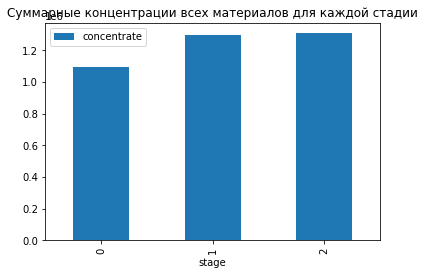

In [34]:
#построим графики, чтобы посмотреть на изменения
concentration_summed.sort_values(by = 'stage').plot.bar(x = 'stage', y = 'concentrate')
plt.title('Суммарные концентрации всех материалов для каждой стадии')

**Выводы**: Мы видим, что суммарная концентрация материалов возрастает после флотации, но почти не меняется после очистки.

## Модель

У нас есть:

Параметры для **обучающей** выборки для чернового концентрата - features_train_rougher <br>
Целевой признак для обучающей выборки для чернового концентрата- target_rougher_train

Параметры для **обучающей** выборки для финального концентрата - features_train <br>
Целевой признак для обучающей выборки для финального концентрата- target_final_train

Параметры для **тестовой** выборки для чернового концентрата - features_test_rougher <br>
Целевой признак для тестовой выборки для чернового концентрата- target_rougher_test

Параметры для **тестовой** выборки для финального концентрата - features_test <br>
Целевой признак для тестовой выборки для финального концентрата- target_final_test

----
Нужно обучить две модели - для чернового и для финального концентрата на обучающей выборке, а затем подсчитать sMAPE на данных тестовой выборки для этих двух моделей.

Итоговое sMAPE = 0.25*sMAPE_rougher + 0.75*sMAPE_final<br>
sMAPE = mean(abs(predicted - true)/((abs(predicted) + abs(true))/2))*100

In [35]:
#Напишем функцию для вычисления итогового sMAPE, нам понадобятся:
#Две модели (черновая и итоговая)
#Две тестовые выборки фичей (черновая и итоговая)
#Два тестовых таргета (черновой и итоговый)

#Сначала напишем просто фукнцию sMAPE (для скора в кросс-валидации)
def smape(y_true, y_predicted):
    sMAPE = np.mean(abs(y_predicted - y_true)\
                         /((abs(y_predicted)+ abs(y_true))/2))*100
    return sMAPE

In [36]:
def smape_final(model_rougher, model_final, features_rougher,\
                features_final, target_rougher, target_final):
    
    predict_rougher = model_rougher.predict(features_rougher)
    sMAPE_rougher = smape(target_rougher, predict_rougher)
    
    predict_final = model_final.predict(features_final)
    sMAPE_final = smape(target_final,predict_final)
    
    sMAPE = 0.25*sMAPE_rougher + 0.75*sMAPE_final
    return sMAPE

In [37]:
#Создадим scorer для кросс-валидации на основе sMAPE
smape_scorer = make_scorer(smape, greater_is_better = False)

Теперь обучим и проверим несколько моделей


В обучении будут использоваться только эти четыре выборки:
    
    Параметры для обучающей выборки для чернового концентрата - features_train_rougher
    Целевой признак для обучающей выборки для чернового концентрата- target_rougher_train

    Параметры для обучающей выборки для финального концентрата - features_train
    Целевой признак для обучающей выборки для финального концентрата- target_final_train

Мы дополнительно разделим их на обучающую и валидационную

### Модель 1: Дерево решений

In [38]:
def run_tree(features, target):
    best_tree_model = None
    best_tree_result = 1000
    best_tree_depth = 0
    for depth in range(1, 10):
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth) #опробуем разную глубину
        scores = cross_val_score(estimator = model, X = features, y = target, scoring = smape_scorer, cv=5)
        result = scores.mean()
        if result < best_tree_result:
            best_tree_model = model
            best_tree_depth = depth
            best_tree_result = result
    return best_tree_model, best_tree_depth, best_tree_result

In [39]:
best_tree_model, best_tree_depth, best_tree_result = run_tree(features_train_rougher,target_rougher_train)
print("sMAPE лучшей модели дерева решений на валидационной выборке после кросс-валидации (черновой):", abs(best_tree_result), ", с глубиной", best_tree_depth)

sMAPE лучшей модели дерева решений на валидационной выборке после кросс-валидации (черновой): 9.202459923497806 , с глубиной 9


In [40]:
best_tree_model_final, best_tree_depth_final, best_tree_result_final = run_tree(features_train, target_final_train)
print("sMAPE лучшей модели дерева решений на валидационной выборке (финальный):", abs(best_tree_result_final), ", с глубиной", best_tree_depth_final)

sMAPE лучшей модели дерева решений на валидационной выборке (финальный): 12.38804121180016 , с глубиной 9


### Модель 2: Случайный лес

In [41]:
def run_forest(features, target):
    best_forest_model = None
    best_forest_result = 1000
    best_forest_depth = 0
    for est in range(10, 31, 10):
        for depth in range (1, 10):
            model = RandomForestRegressor(random_state=12345, n_estimators=est,max_depth=depth)
            scores = cross_val_score(estimator = model, X = features, y = target, scoring = smape_scorer, cv=5)
            result = scores.mean()
            if result < best_forest_result:
                best_forest_model = model
                best_forest_depth = depth
                best_forest_result = result
                best_forest_est = est
    return best_forest_model, best_forest_depth, best_forest_result, best_forest_est

In [42]:
best_forest_model, best_forest_depth, best_forest_result, best_forest_est = run_forest(features_train_rougher,target_rougher_train )
print()        
print("sMAPE лучшей модели случайного леса на валидационной выборке после кросс-валидации (черновой):", abs(best_forest_result))


sMAPE лучшей модели случайного леса на валидационной выборке после кросс-валидации (черновой): 7.766629428658544


In [43]:
best_forest_model_final, best_forest_depth_final, best_forest_result_final, best_forest_est_final = run_forest(features_train,target_final_train )
print()        
print("sMAPE лучшей модели случайного леса на валидационной выборке после кросс-валидации (финальный):", abs(best_forest_result_final))


sMAPE лучшей модели случайного леса на валидационной выборке после кросс-валидации (финальный): 10.113733076579999


### "Глупая" модель

Обучим глупую модель для сравнения с нашей итоговой моделью.
Предсказываем сразу на данных тестововой выборки.

In [44]:
dummy_rougher = DummyRegressor(strategy="median")
dummy_final = DummyRegressor(strategy="median")

In [45]:
dummy_rougher.fit(features_train_rougher, target_rougher_train)
dummy_final.fit(features_train, target_final_train)
smape_dummy = smape_final(dummy_rougher, dummy_final, features_test_rougher,\
                features_test, target_rougher_test, target_final_test)
print('Итогововая метрика sMAPE dummy-модели на тестовой выборке:',smape_dummy )

Итогововая метрика sMAPE dummy-модели на тестовой выборке: 9.019033667420885


## Проверка качества модели на тестовой выборке

In [46]:
#Обучаем модели с выделенными лучшими гиперпараметрами

best_forest_model_rougher = RandomForestRegressor(random_state=12345, n_estimators=best_forest_est\
                                          ,max_depth=best_forest_depth)
best_forest_model_rougher.fit(features_train_rougher, target_rougher_train)

best_forest_model_final = RandomForestRegressor(random_state=12345, n_estimators=best_forest_est_final\
                                          ,max_depth=best_forest_depth_final)
best_forest_model_final.fit(features_train, target_final_train)

RandomForestRegressor(max_depth=9, n_estimators=10, random_state=12345)

In [47]:
smape_final(best_forest_model_rougher, best_forest_model_final, features_test_rougher,\
                features_test, target_rougher_test, target_final_test)

9.364463458837937

Итогововая метрика sMAPE dummy-модели на тестовой выборке: 9.019033667420885 <br>
Итогововая метрика нашей модели на тестовой выборке: 9.364463458837937
